In [1]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST

mnist = MNIST(root='data', 
              train=True, 
              download=True,
              transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw


Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw



Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw


Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw
Processing...


C:\Users\msris\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


In [2]:
# denormalize to view image
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

Label: 5


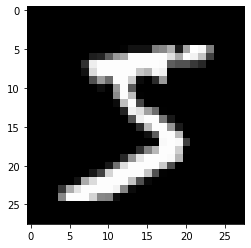

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

img, label = mnist[0]
img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')
print('Label:', label)

In [5]:
from torch.utils.data import DataLoader

batch_size = 100
data_loader = DataLoader(mnist, batch_size, shuffle=True)

first batch
torch.Size([100, 1, 28, 28])
tensor([4, 1, 0, 8, 8, 1, 3, 8, 4, 8, 9, 5, 0, 0, 2, 1, 3, 7, 9, 5, 0, 9, 3, 4,
        0, 4, 5, 9, 0, 8, 0, 7, 4, 5, 7, 8, 3, 7, 0, 4, 1, 2, 7, 9, 1, 7, 7, 8,
        2, 2, 0, 3, 6, 9, 9, 8, 5, 2, 7, 1, 7, 4, 4, 6, 0, 9, 1, 8, 7, 1, 4, 0,
        0, 5, 8, 1, 7, 4, 5, 3, 8, 2, 8, 1, 1, 6, 9, 8, 5, 3, 7, 6, 3, 5, 6, 5,
        1, 9, 9, 6])


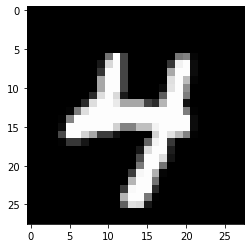

In [6]:
for img_batch, label_batch in data_loader:
    print('first batch')
    print(img_batch.shape)
    plt.imshow(img_batch[0][0], cmap='gray')
    print(label_batch)
    break

In [7]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
device

device(type='cuda')

In [9]:
image_size = 784
hidden_size = 256

In [10]:
import torch.nn as nn

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

In [11]:
D.to(device)

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

In [12]:
latent_size = 64
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

In [13]:
y = G(torch.randn(2, latent_size))
gen_imgs = denorm(y.reshape((-1, 28,28)).detach())

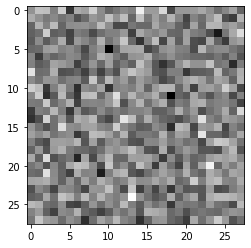

In [14]:
plt.imshow(gen_imgs[1], cmap='gray');

In [15]:
G.to(device)

In [16]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
## Let's define helper functions to reset gradients and train the discriminator.

def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)
        
    # Loss for real images
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    d_optimizer.step()
    
    return d_loss, real_score, fake_score

In [17]:
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)
def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

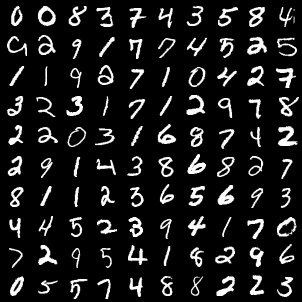

In [18]:
import os

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)
# Let's save a batch of real images that we can use for visual comparision while looking at the generated images.

from IPython.display import Image
from torchvision.utils import save_image

# Save some real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break
   
Image(os.path.join(sample_dir, 'real_images.png'))

Saving fake_images-0000.png


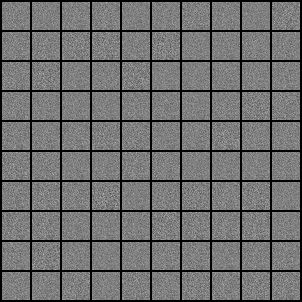

In [19]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)
    
# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

In [20]:
%%time

num_epochs = 300
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)
        
        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()
        
        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
        
    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/300], Step [200/600], d_loss: 0.0740, g_loss: 3.5831, D(x): 0.99, D(G(z)): 0.06
Epoch [0/300], Step [400/600], d_loss: 0.0637, g_loss: 4.6797, D(x): 0.98, D(G(z)): 0.04
Epoch [0/300], Step [600/600], d_loss: 0.1572, g_loss: 4.8329, D(x): 0.94, D(G(z)): 0.05
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.0298, g_loss: 4.9060, D(x): 0.99, D(G(z)): 0.02
Epoch [1/300], Step [400/600], d_loss: 0.1984, g_loss: 5.9881, D(x): 0.91, D(G(z)): 0.07
Epoch [1/300], Step [600/600], d_loss: 0.2289, g_loss: 3.4340, D(x): 0.94, D(G(z)): 0.10
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.0796, g_loss: 4.6783, D(x): 0.97, D(G(z)): 0.04
Epoch [2/300], Step [400/600], d_loss: 0.2366, g_loss: 3.8361, D(x): 0.91, D(G(z)): 0.06
Epoch [2/300], Step [600/600], d_loss: 0.2403, g_loss: 3.9060, D(x): 0.94, D(G(z)): 0.14
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 0.6619, g_loss: 2.5203, D(x): 0.87, D(G(z)): 0.32
Epoch [3/300], Step [400/6

Epoch [27/300], Step [600/600], d_loss: 0.3414, g_loss: 4.5728, D(x): 0.87, D(G(z)): 0.07
Saving fake_images-0028.png
Epoch [28/300], Step [200/600], d_loss: 0.3598, g_loss: 3.5152, D(x): 0.85, D(G(z)): 0.05
Epoch [28/300], Step [400/600], d_loss: 0.6724, g_loss: 4.4345, D(x): 0.92, D(G(z)): 0.24
Epoch [28/300], Step [600/600], d_loss: 0.3255, g_loss: 4.2224, D(x): 0.90, D(G(z)): 0.09
Saving fake_images-0029.png
Epoch [29/300], Step [200/600], d_loss: 0.2519, g_loss: 4.2342, D(x): 0.90, D(G(z)): 0.06
Epoch [29/300], Step [400/600], d_loss: 0.4684, g_loss: 3.6844, D(x): 0.86, D(G(z)): 0.08
Epoch [29/300], Step [600/600], d_loss: 0.5083, g_loss: 3.5962, D(x): 0.95, D(G(z)): 0.28
Saving fake_images-0030.png
Epoch [30/300], Step [200/600], d_loss: 0.3234, g_loss: 6.3384, D(x): 0.88, D(G(z)): 0.04
Epoch [30/300], Step [400/600], d_loss: 0.4019, g_loss: 3.7895, D(x): 0.91, D(G(z)): 0.14
Epoch [30/300], Step [600/600], d_loss: 0.5183, g_loss: 3.6194, D(x): 0.92, D(G(z)): 0.23
Saving fake_imag

Epoch [55/300], Step [400/600], d_loss: 0.5704, g_loss: 2.1177, D(x): 0.86, D(G(z)): 0.26
Epoch [55/300], Step [600/600], d_loss: 0.4584, g_loss: 2.4565, D(x): 0.83, D(G(z)): 0.14
Saving fake_images-0056.png
Epoch [56/300], Step [200/600], d_loss: 0.5938, g_loss: 3.2036, D(x): 0.87, D(G(z)): 0.26
Epoch [56/300], Step [400/600], d_loss: 0.5579, g_loss: 2.5645, D(x): 0.82, D(G(z)): 0.18
Epoch [56/300], Step [600/600], d_loss: 0.7109, g_loss: 2.6194, D(x): 0.73, D(G(z)): 0.15
Saving fake_images-0057.png
Epoch [57/300], Step [200/600], d_loss: 0.5179, g_loss: 3.3277, D(x): 0.80, D(G(z)): 0.14
Epoch [57/300], Step [400/600], d_loss: 0.5352, g_loss: 3.0808, D(x): 0.85, D(G(z)): 0.20
Epoch [57/300], Step [600/600], d_loss: 0.5457, g_loss: 2.4246, D(x): 0.78, D(G(z)): 0.11
Saving fake_images-0058.png
Epoch [58/300], Step [200/600], d_loss: 0.6606, g_loss: 3.1099, D(x): 0.72, D(G(z)): 0.08
Epoch [58/300], Step [400/600], d_loss: 0.5995, g_loss: 2.7097, D(x): 0.80, D(G(z)): 0.18
Epoch [58/300], 

Epoch [83/300], Step [200/600], d_loss: 0.6470, g_loss: 2.2217, D(x): 0.82, D(G(z)): 0.24
Epoch [83/300], Step [400/600], d_loss: 0.7211, g_loss: 1.9995, D(x): 0.78, D(G(z)): 0.24
Epoch [83/300], Step [600/600], d_loss: 0.7282, g_loss: 1.3968, D(x): 0.82, D(G(z)): 0.30
Saving fake_images-0084.png
Epoch [84/300], Step [200/600], d_loss: 0.9618, g_loss: 1.7988, D(x): 0.77, D(G(z)): 0.36
Epoch [84/300], Step [400/600], d_loss: 0.6269, g_loss: 2.0674, D(x): 0.78, D(G(z)): 0.21
Epoch [84/300], Step [600/600], d_loss: 0.8201, g_loss: 2.0184, D(x): 0.70, D(G(z)): 0.21
Saving fake_images-0085.png
Epoch [85/300], Step [200/600], d_loss: 0.4939, g_loss: 2.6977, D(x): 0.87, D(G(z)): 0.24
Epoch [85/300], Step [400/600], d_loss: 0.7790, g_loss: 1.4163, D(x): 0.76, D(G(z)): 0.28
Epoch [85/300], Step [600/600], d_loss: 0.6789, g_loss: 1.6914, D(x): 0.80, D(G(z)): 0.27
Saving fake_images-0086.png
Epoch [86/300], Step [200/600], d_loss: 0.8965, g_loss: 2.0334, D(x): 0.73, D(G(z)): 0.25
Epoch [86/300], 

Epoch [110/300], Step [600/600], d_loss: 0.8609, g_loss: 1.8874, D(x): 0.72, D(G(z)): 0.29
Saving fake_images-0111.png
Epoch [111/300], Step [200/600], d_loss: 1.1639, g_loss: 1.4892, D(x): 0.70, D(G(z)): 0.35
Epoch [111/300], Step [400/600], d_loss: 0.8813, g_loss: 1.7009, D(x): 0.80, D(G(z)): 0.36
Epoch [111/300], Step [600/600], d_loss: 0.9486, g_loss: 1.2825, D(x): 0.66, D(G(z)): 0.29
Saving fake_images-0112.png
Epoch [112/300], Step [200/600], d_loss: 0.8953, g_loss: 1.5671, D(x): 0.70, D(G(z)): 0.26
Epoch [112/300], Step [400/600], d_loss: 0.8185, g_loss: 2.0178, D(x): 0.81, D(G(z)): 0.36
Epoch [112/300], Step [600/600], d_loss: 0.8461, g_loss: 1.6928, D(x): 0.70, D(G(z)): 0.26
Saving fake_images-0113.png
Epoch [113/300], Step [200/600], d_loss: 1.0146, g_loss: 1.3189, D(x): 0.71, D(G(z)): 0.33
Epoch [113/300], Step [400/600], d_loss: 0.9296, g_loss: 1.7861, D(x): 0.66, D(G(z)): 0.26
Epoch [113/300], Step [600/600], d_loss: 0.9121, g_loss: 1.8211, D(x): 0.73, D(G(z)): 0.29
Saving

Epoch [138/300], Step [200/600], d_loss: 0.9198, g_loss: 1.0865, D(x): 0.71, D(G(z)): 0.31
Epoch [138/300], Step [400/600], d_loss: 0.8858, g_loss: 1.6998, D(x): 0.68, D(G(z)): 0.27
Epoch [138/300], Step [600/600], d_loss: 0.9324, g_loss: 1.0237, D(x): 0.79, D(G(z)): 0.41
Saving fake_images-0139.png
Epoch [139/300], Step [200/600], d_loss: 0.9163, g_loss: 1.3005, D(x): 0.78, D(G(z)): 0.37
Epoch [139/300], Step [400/600], d_loss: 1.0438, g_loss: 1.3621, D(x): 0.58, D(G(z)): 0.26
Epoch [139/300], Step [600/600], d_loss: 0.9090, g_loss: 1.4272, D(x): 0.72, D(G(z)): 0.33
Saving fake_images-0140.png
Epoch [140/300], Step [200/600], d_loss: 0.8874, g_loss: 1.3656, D(x): 0.73, D(G(z)): 0.32
Epoch [140/300], Step [400/600], d_loss: 0.8439, g_loss: 1.3574, D(x): 0.76, D(G(z)): 0.33
Epoch [140/300], Step [600/600], d_loss: 0.8494, g_loss: 1.7493, D(x): 0.69, D(G(z)): 0.26
Saving fake_images-0141.png
Epoch [141/300], Step [200/600], d_loss: 0.9073, g_loss: 1.3693, D(x): 0.69, D(G(z)): 0.29
Epoch 

Epoch [165/300], Step [400/600], d_loss: 0.8007, g_loss: 1.6805, D(x): 0.72, D(G(z)): 0.27
Epoch [165/300], Step [600/600], d_loss: 0.9844, g_loss: 1.3674, D(x): 0.68, D(G(z)): 0.32
Saving fake_images-0166.png
Epoch [166/300], Step [200/600], d_loss: 0.9179, g_loss: 1.4469, D(x): 0.70, D(G(z)): 0.28
Epoch [166/300], Step [400/600], d_loss: 1.0305, g_loss: 1.4364, D(x): 0.64, D(G(z)): 0.31
Epoch [166/300], Step [600/600], d_loss: 0.7448, g_loss: 1.8915, D(x): 0.72, D(G(z)): 0.24
Saving fake_images-0167.png
Epoch [167/300], Step [200/600], d_loss: 0.9975, g_loss: 1.9120, D(x): 0.63, D(G(z)): 0.26
Epoch [167/300], Step [400/600], d_loss: 0.8999, g_loss: 1.5087, D(x): 0.73, D(G(z)): 0.35
Epoch [167/300], Step [600/600], d_loss: 0.9385, g_loss: 1.6629, D(x): 0.68, D(G(z)): 0.28
Saving fake_images-0168.png
Epoch [168/300], Step [200/600], d_loss: 0.9890, g_loss: 1.3706, D(x): 0.79, D(G(z)): 0.42
Epoch [168/300], Step [400/600], d_loss: 0.9575, g_loss: 1.4565, D(x): 0.68, D(G(z)): 0.32
Epoch 

Epoch [192/300], Step [600/600], d_loss: 1.0625, g_loss: 1.1621, D(x): 0.80, D(G(z)): 0.43
Saving fake_images-0193.png
Epoch [193/300], Step [200/600], d_loss: 0.8438, g_loss: 1.3780, D(x): 0.74, D(G(z)): 0.33
Epoch [193/300], Step [400/600], d_loss: 0.9782, g_loss: 1.7742, D(x): 0.68, D(G(z)): 0.34
Epoch [193/300], Step [600/600], d_loss: 0.9889, g_loss: 0.9542, D(x): 0.63, D(G(z)): 0.30
Saving fake_images-0194.png
Epoch [194/300], Step [200/600], d_loss: 0.9426, g_loss: 1.4272, D(x): 0.72, D(G(z)): 0.34
Epoch [194/300], Step [400/600], d_loss: 0.9894, g_loss: 1.4296, D(x): 0.66, D(G(z)): 0.30
Epoch [194/300], Step [600/600], d_loss: 1.0997, g_loss: 1.5103, D(x): 0.72, D(G(z)): 0.39
Saving fake_images-0195.png
Epoch [195/300], Step [200/600], d_loss: 0.9842, g_loss: 1.4826, D(x): 0.74, D(G(z)): 0.37
Epoch [195/300], Step [400/600], d_loss: 0.9131, g_loss: 1.6361, D(x): 0.72, D(G(z)): 0.34
Epoch [195/300], Step [600/600], d_loss: 0.9310, g_loss: 1.6785, D(x): 0.68, D(G(z)): 0.29
Saving

Epoch [220/300], Step [200/600], d_loss: 0.9158, g_loss: 1.3636, D(x): 0.71, D(G(z)): 0.32
Epoch [220/300], Step [400/600], d_loss: 1.0498, g_loss: 1.6791, D(x): 0.61, D(G(z)): 0.28
Epoch [220/300], Step [600/600], d_loss: 1.0256, g_loss: 1.3503, D(x): 0.67, D(G(z)): 0.35
Saving fake_images-0221.png
Epoch [221/300], Step [200/600], d_loss: 0.8848, g_loss: 1.7629, D(x): 0.73, D(G(z)): 0.32
Epoch [221/300], Step [400/600], d_loss: 1.0081, g_loss: 1.2997, D(x): 0.62, D(G(z)): 0.27
Epoch [221/300], Step [600/600], d_loss: 0.8096, g_loss: 1.4289, D(x): 0.79, D(G(z)): 0.35
Saving fake_images-0222.png
Epoch [222/300], Step [200/600], d_loss: 0.9079, g_loss: 1.2603, D(x): 0.72, D(G(z)): 0.33
Epoch [222/300], Step [400/600], d_loss: 1.1075, g_loss: 1.4123, D(x): 0.61, D(G(z)): 0.31
Epoch [222/300], Step [600/600], d_loss: 1.0061, g_loss: 1.2612, D(x): 0.75, D(G(z)): 0.40
Saving fake_images-0223.png
Epoch [223/300], Step [200/600], d_loss: 1.1727, g_loss: 1.1853, D(x): 0.66, D(G(z)): 0.39
Epoch 

Epoch [247/300], Step [400/600], d_loss: 0.9351, g_loss: 1.4406, D(x): 0.61, D(G(z)): 0.22
Epoch [247/300], Step [600/600], d_loss: 1.1171, g_loss: 1.5768, D(x): 0.70, D(G(z)): 0.36
Saving fake_images-0248.png
Epoch [248/300], Step [200/600], d_loss: 0.9937, g_loss: 1.8444, D(x): 0.68, D(G(z)): 0.33
Epoch [248/300], Step [400/600], d_loss: 0.9357, g_loss: 1.2114, D(x): 0.73, D(G(z)): 0.36
Epoch [248/300], Step [600/600], d_loss: 1.1366, g_loss: 1.2419, D(x): 0.60, D(G(z)): 0.30
Saving fake_images-0249.png
Epoch [249/300], Step [200/600], d_loss: 0.9869, g_loss: 1.6581, D(x): 0.61, D(G(z)): 0.25
Epoch [249/300], Step [400/600], d_loss: 0.8976, g_loss: 1.4841, D(x): 0.75, D(G(z)): 0.36
Epoch [249/300], Step [600/600], d_loss: 1.0059, g_loss: 1.4314, D(x): 0.66, D(G(z)): 0.32
Saving fake_images-0250.png
Epoch [250/300], Step [200/600], d_loss: 0.9701, g_loss: 1.3312, D(x): 0.67, D(G(z)): 0.29
Epoch [250/300], Step [400/600], d_loss: 0.8595, g_loss: 1.5425, D(x): 0.72, D(G(z)): 0.29
Epoch 

Epoch [274/300], Step [600/600], d_loss: 1.0229, g_loss: 1.2681, D(x): 0.76, D(G(z)): 0.42
Saving fake_images-0275.png
Epoch [275/300], Step [200/600], d_loss: 1.1462, g_loss: 1.4443, D(x): 0.59, D(G(z)): 0.30
Epoch [275/300], Step [400/600], d_loss: 0.9073, g_loss: 1.2016, D(x): 0.78, D(G(z)): 0.37
Epoch [275/300], Step [600/600], d_loss: 1.1071, g_loss: 1.3134, D(x): 0.64, D(G(z)): 0.33
Saving fake_images-0276.png
Epoch [276/300], Step [200/600], d_loss: 0.9007, g_loss: 1.4476, D(x): 0.69, D(G(z)): 0.31
Epoch [276/300], Step [400/600], d_loss: 0.9495, g_loss: 1.4054, D(x): 0.69, D(G(z)): 0.33
Epoch [276/300], Step [600/600], d_loss: 0.9108, g_loss: 1.7150, D(x): 0.70, D(G(z)): 0.32
Saving fake_images-0277.png
Epoch [277/300], Step [200/600], d_loss: 0.9714, g_loss: 1.4719, D(x): 0.71, D(G(z)): 0.36
Epoch [277/300], Step [400/600], d_loss: 0.9299, g_loss: 1.3722, D(x): 0.74, D(G(z)): 0.35
Epoch [277/300], Step [600/600], d_loss: 1.0177, g_loss: 1.7178, D(x): 0.65, D(G(z)): 0.29
Saving

In [21]:
import cv2
import os
from IPython.display import FileLink

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'fake_images' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 8, (302,302))
[out.write(cv2.imread(fname)) for fname in files]
out.release()
FileLink('gans_training.avi')

C:\Users\msris\OneDrive\Documents\PyTorch\gans_training.avi

In [22]:
# Save the model checkpoints 
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')